# 📊 Taxi Pricing Benchmark - Complete Analysis

## 🎯 Analysis Structure

Each plot shows **3 variants per method:**
1. **Method_PL** - PL acceptance function only
2. **Method_Sigmoid** - Sigmoid acceptance function only
3. **Method_Avg** - Average of PL and Sigmoid

**Plot Layout:**
- **Left:** Individual experiments (different dates, different line styles)
- **Right:** Averaged across all experiments (smooth lines with confidence bands)

## 📈 Two Metrics Explained

### 1. Customer Revenue (Business Perspective)
- **Field:** `profit`
- **Formula:** Σ(price)
- **Meaning:** What customers PAY (gross revenue)
- **Example:** Customer pays $30 → revenue = $30

### 2. System Total Value (Efficiency Perspective)
- **Field:** `total_value`  
- **Formula:** Σ(price + edge_weight)
- **Meaning:** What system GAINS (revenue accounting for costs)
- **Example:** Customer pays $30, matching costs $15 → total_value = $15

**Why different?** Edge weights are typically NEGATIVE (costs like driver travel distance).

## ⚙️ Configuration

Update Cell 2 with your experiment parameters.

In [23]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import io
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Use Set2 color palette (colorblind-friendly)
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

PLOTS_DIR = Path('plots')
PLOTS_DIR.mkdir(exist_ok=True)

# S3 Configuration
S3_BUCKET = "taxi-benchmark"
S3_EXPERIMENTS_PREFIX = "experiments/"
AWS_REGION = "eu-north-1"
s3_client = boto3.client('s3', region_name=AWS_REGION)

print("✅ Setup complete")

✅ Setup complete


In [24]:
# Configuration

EXPERIMENT_IDS = [
    "20191006_yellow_Man_LP_MinMaxCostFlow_20251115_122937",
    # Add more here
]

EXPERIMENT_CONFIG = {
    'start_hour': 0,
    'time_delta': 10,  # minutes
}

# Color scheme (Set2 is colorblind-friendly)
COLOR_PALETTE = 'Set2'

print(f"📋 Config: {len(EXPERIMENT_IDS)} experiments, {COLOR_PALETTE} colors")

📋 Config: 1 experiments, Set2 colors


In [25]:
# Data Loading

def load_experiment_from_s3(experiment_id: str) -> pd.DataFrame:
    print(f"📥 {experiment_id}...")
    try:
        response = s3_client.list_objects_v2(
            Bucket=S3_BUCKET,
            Prefix=f"{S3_EXPERIMENTS_PREFIX}{experiment_id}/decisions/"
        )
        parquet_files = [o for o in response.get('Contents', []) if o['Key'].endswith('.parquet')]
        dfs = []
        for obj in parquet_files:
            resp = s3_client.get_object(Bucket=S3_BUCKET, Key=obj['Key'])
            dfs.append(pd.read_parquet(io.BytesIO(resp['Body'].read())))
        if dfs:
            combined = pd.concat(dfs, ignore_index=True)
            print(f"  ✅ {len(combined):,} records")
            print(f"  📊 Acceptance funcs: {sorted(combined['acceptance_function'].unique())}")
            return combined
        return pd.DataFrame()
    except Exception as e:
        print(f"  ❌ Error: {e}")
        return pd.DataFrame()

def load_all_experiments(exp_ids):
    experiments = {}
    for exp_id in exp_ids:
        df = load_experiment_from_s3(exp_id)
        if not df.empty:
            experiments[exp_id] = df
    return experiments

print("✅ Data loading ready")

✅ Data loading ready


In [26]:
# Helper Functions

def to_hour(tw_idx):
    return EXPERIMENT_CONFIG['start_hour'] + tw_idx * (EXPERIMENT_CONFIG['time_delta'] / 60.0)

def prepare_method_variants(df, method_name):
    """Prepare 3 variants: PL, Sigmoid, and Average."""
    method_data = df[df['method'] == method_name].copy()
    
    variants = {}
    
    # PL only
    variants[f'{method_name}_PL'] = method_data[method_data['acceptance_function'] == 'PL'].copy()
    
    # Sigmoid only
    variants[f'{method_name}_Sigmoid'] = method_data[method_data['acceptance_function'] == 'Sigmoid'].copy()
    
    # Average (combine both)
    variants[f'{method_name}_Avg'] = method_data.copy()
    
    return variants

def aggregate_hourly(df, value_field):
    """Aggregate by hour with correct opt_value handling."""
    df = df.copy()
    df['hour'] = df['time_window_idx'].apply(to_hour)
    
    if value_field == 'opt_value':
        # CRITICAL: Take first per time_window, then sum per hour
        return df.groupby(['hour', 'time_window_idx'])[value_field].first().groupby('hour').sum().sort_index()
    else:
        return df.groupby('hour')[value_field].sum().sort_index()

def get_method_colors():
    """Get distinct colors for each method variant."""
    # Using Set2 palette - 8 distinct colors
    base_colors = plt.cm.Set2(np.linspace(0, 1, 8))
    
    colors = {
        'LP_PL': base_colors[0],           # Green
        'LP_Sigmoid': base_colors[1],      # Orange
        'LP_Avg': base_colors[2],          # Blue
        'MinMaxCostFlow_PL': base_colors[3],      # Pink
        'MinMaxCostFlow_Sigmoid': base_colors[4], # Light green
        'MinMaxCostFlow_Avg': base_colors[5],     # Yellow
    }
    return colors

print("✅ Helpers ready")

✅ Helpers ready


In [27]:
# Plot 1: Customer Revenue Comparison

def plot_customer_revenue(experiments_data, save=True):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    colors = get_method_colors()
    
    # Get all methods
    all_methods = sorted(set(m for df in experiments_data.values() for m in df['method'].unique()))
    
    # Left: Individual experiments
    for exp_idx, (exp_id, df) in enumerate(experiments_data.items()):
        exp_date = exp_id.split('_')[0]
        linestyle = ['-', '--', '-.', ':'][exp_idx % 4]
        
        for method in all_methods:
            if method not in df['method'].values:
                continue
            
            # Get 3 variants: PL, Sigmoid, Avg
            variants = prepare_method_variants(df, method)
            
            for var_name, var_df in variants.items():
                if var_df.empty:
                    continue
                hourly = aggregate_hourly(var_df, 'profit').cumsum()
                ax1.plot(hourly.index, hourly.values, color=colors[var_name],
                        linestyle=linestyle, alpha=0.7, linewidth=2,
                        label=f"{var_name} ({exp_date})")
    
    ax1.set_xlabel('Hour', fontsize=13)
    ax1.set_ylabel('Cumulative Revenue ($)', fontsize=13)
    ax1.set_title('Customer Revenue (What Customers Pay)\nIndividual Experiments', 
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=8, ncol=2)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 24)
    
    # Right: Averaged across experiments
    for method in all_methods:
        for acc_func in ['PL', 'Sigmoid', 'Avg']:
            var_name = f"{method}_{acc_func}"
            all_cumulative = []
            
            for df in experiments_data.values():
                if method not in df['method'].values:
                    continue
                variants = prepare_method_variants(df, method)
                if var_name in variants and not variants[var_name].empty:
                    hourly = aggregate_hourly(variants[var_name], 'profit').cumsum()
                    all_cumulative.append(hourly)
            
            if all_cumulative:
                all_hours = sorted(set(h for c in all_cumulative for h in c.index))
                aligned = pd.DataFrame(index=all_hours)
                for j, c in enumerate(all_cumulative):
                    aligned[f'exp_{j}'] = c
                aligned = aligned.fillna(method='ffill')
                mean = aligned.mean(axis=1)
                std = aligned.std(axis=1)
                
                marker = 'o' if acc_func == 'Avg' else None
                linewidth = 3.5 if acc_func == 'Avg' else 2.5
                alpha = 1.0 if acc_func == 'Avg' else 0.7
                
                ax2.plot(mean.index, mean.values, color=colors[var_name],
                        linewidth=linewidth, alpha=alpha, label=var_name, marker=marker, markersize=4)
                if acc_func == 'Avg':
                    ax2.fill_between(mean.index, mean - std, mean + std,
                                   color=colors[var_name], alpha=0.15)
    
    ax2.set_xlabel('Hour', fontsize=13)
    ax2.set_ylabel('Cumulative Revenue ($)', fontsize=13)
    ax2.set_title('Customer Revenue (What Customers Pay)\nAveraged Across Experiments', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9, ncol=2)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "1_customer_revenue.png", dpi=300, bbox_inches='tight')
        print("💾 Saved: 1_customer_revenue.png")
    plt.show()

print("✅ Revenue plot function loaded")

✅ Revenue plot function loaded


In [28]:
# Plot 2: System Total Value (Apple-to-Apple!)

def plot_system_total_value(experiments_data, save=True):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    colors = get_method_colors()
    all_methods = sorted(set(m for df in experiments_data.values() for m in df['method'].unique()))
    
    # Left: Individual experiments
    for exp_idx, (exp_id, df) in enumerate(experiments_data.items()):
        exp_date = exp_id.split('_')[0]
        linestyle = ['-', '--', '-.', ':'][exp_idx % 4]
        
        for method in all_methods:
            if method not in df['method'].values:
                continue
            variants = prepare_method_variants(df, method)
            
            for var_name, var_df in variants.items():
                if var_df.empty:
                    continue
                hourly = aggregate_hourly(var_df, 'total_value').cumsum()
                ax1.plot(hourly.index, hourly.values, color=colors[var_name],
                        linestyle=linestyle, alpha=0.7, linewidth=2,
                        label=f"{var_name} ({exp_date})")
    
    ax1.set_xlabel('Hour', fontsize=13)
    ax1.set_ylabel('Cumulative Total Value ($)', fontsize=13)
    ax1.set_title('System Total Value (Revenue + Costs)\nIndividual Experiments', 
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=8, ncol=2)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 24)
    
    # Right: Averaged with LP optimal
    for method in all_methods:
        for acc_func in ['PL', 'Sigmoid', 'Avg']:
            var_name = f"{method}_{acc_func}"
            all_cumulative = []
            
            for df in experiments_data.values():
                if method not in df['method'].values:
                    continue
                variants = prepare_method_variants(df, method)
                if var_name in variants and not variants[var_name].empty:
                    hourly = aggregate_hourly(variants[var_name], 'total_value').cumsum()
                    all_cumulative.append(hourly)
            
            if all_cumulative:
                all_hours = sorted(set(h for c in all_cumulative for h in c.index))
                aligned = pd.DataFrame(index=all_hours)
                for j, c in enumerate(all_cumulative):
                    aligned[f'exp_{j}'] = c
                aligned = aligned.fillna(method='ffill')
                mean = aligned.mean(axis=1)
                std = aligned.std(axis=1)
                
                marker = 'o' if acc_func == 'Avg' else None
                linewidth = 3.5 if acc_func == 'Avg' else 2.5
                alpha = 1.0 if acc_func == 'Avg' else 0.7
                
                ax2.plot(mean.index, mean.values, color=colors[var_name],
                        linewidth=linewidth, alpha=alpha, 
                        label=f"{var_name} (realized)", marker=marker, markersize=4)
                if acc_func == 'Avg':
                    ax2.fill_between(mean.index, mean - std, mean + std,
                                   color=colors[var_name], alpha=0.15)
    
    # Add LP optimal lines for PL and Sigmoid
    if 'LP' in all_methods:
        for acc_func in ['PL', 'Sigmoid']:
            var_name = f"LP_{acc_func}"
            all_opt = []
            
            for df in experiments_data.values():
                if 'LP' in df['method'].values:
                    variants = prepare_method_variants(df, 'LP')
                    if var_name in variants and not variants[var_name].empty:
                        hourly = aggregate_hourly(variants[var_name], 'opt_value').cumsum()
                        all_opt.append(hourly)
            
            if all_opt:
                all_hours = sorted(set(h for o in all_opt for h in o.index))
                aligned = pd.DataFrame(index=all_hours)
                for j, o in enumerate(all_opt):
                    aligned[f'exp_{j}'] = o
                aligned = aligned.fillna(method='ffill')
                mean_opt = aligned.mean(axis=1)
                
                ax2.plot(mean_opt.index, mean_opt.values, '--',
                        color=colors[var_name], linewidth=2.5, alpha=0.8,
                        label=f"LP_{acc_func} (optimal)", marker='s', markersize=3)
    
    ax2.set_xlabel('Hour', fontsize=13)
    ax2.set_ylabel('Cumulative Total Value ($)', fontsize=13)
    ax2.set_title('System Total Value (Revenue + Costs)\n🍎 Apple-to-Apple: All include matching costs!', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=8, ncol=2)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "2_system_total_value.png", dpi=300, bbox_inches='tight')
        print("💾 Saved: 2_system_total_value.png")
    plt.show()

print("✅ Total value plot function loaded")

✅ Total value plot function loaded


In [29]:
# Summary Statistics

def print_summary(experiments_data):
    print("="*100)
    print("📊 COMPREHENSIVE SUMMARY")
    print("="*100)
    
    all_stats = []
    
    for exp_id, df in experiments_data.items():
        exp_date = exp_id.split('_')[0]
        
        for method in sorted(df['method'].unique()):
            for acc_func in ['PL', 'Sigmoid']:
                data = df[(df['method'] == method) & (df['acceptance_function'] == acc_func)]
                
                if data.empty:
                    continue
                
                # Calculate metrics
                revenue = data['profit'].sum()
                total_val = data['total_value'].sum()
                
                stats = {
                    'Exp': exp_date,
                    'Method': method,
                    'AcceptFunc': acc_func,
                    'Records': len(data),
                    'Revenue': f"${revenue:,.0f}",
                    'TotalValue': f"${total_val:,.0f}",
                    'AcceptRate': f"{data['sampled_decision'].mean():.1%}",
                    'MatchRate': f"{data['was_matched'].mean():.1%}",
                }
                
                # LP optimality
                if method == 'LP':
                    opt = data.groupby('time_window_idx')['opt_value'].first().sum()
                    optimality = total_val / opt if opt > 0 else 0
                    stats['LP_Optimal'] = f"${opt:,.0f}"
                    stats['Optimality'] = f"{optimality:.1%}"
                
                all_stats.append(stats)
    
    df_summary = pd.DataFrame(all_stats)
    print(df_summary.to_string(index=False))
    print("\n" + "="*100)
    
    return df_summary

print("✅ Summary function loaded")

✅ Summary function loaded


🚀 Loading experiments...

📥 20191006_yellow_Man_LP_MinMaxCostFlow_20251115_122937...
  ✅ 33,844 records
  📊 Acceptance funcs: ['PL', 'Sigmoid']

✅ Loaded 1 experiments
   Total records: 33,844


📊 COMPREHENSIVE SUMMARY
     Exp         Method AcceptFunc  Records  Revenue TotalValue AcceptRate MatchRate LP_Optimal Optimality
20191006             LP         PL     8461 $144,581   $137,649      94.9%     95.0%   $115,533     119.1%
20191006             LP    Sigmoid     8461 $121,031   $115,563      80.4%     79.9%   $103,989     111.1%
20191006 MinMaxCostFlow         PL     8461 $148,286   $138,772     100.0%     97.7%        NaN        NaN
20191006 MinMaxCostFlow    Sigmoid     8461 $138,912   $130,590      93.6%     92.2%        NaN        NaN


🎨 GENERATING PLOTS

📊 1. Customer Revenue (Business Perspective)
💾 Saved: 1_customer_revenue.png


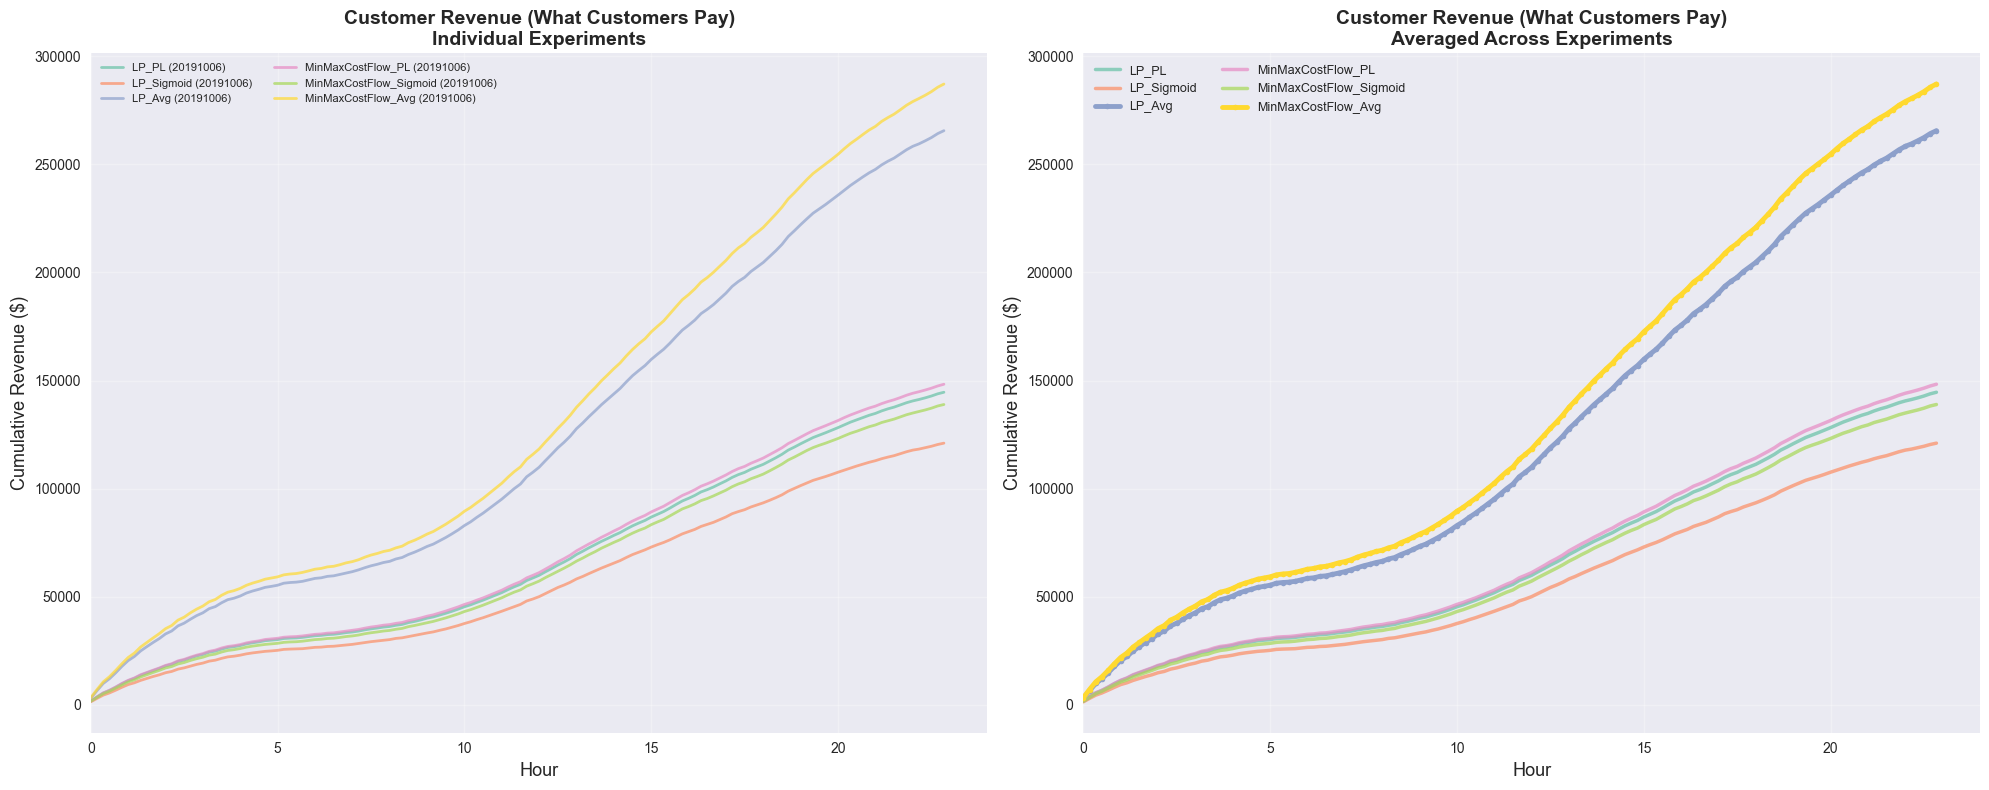


📊 2. System Total Value (Efficiency Perspective - Apple-to-Apple!)
💾 Saved: 2_system_total_value.png


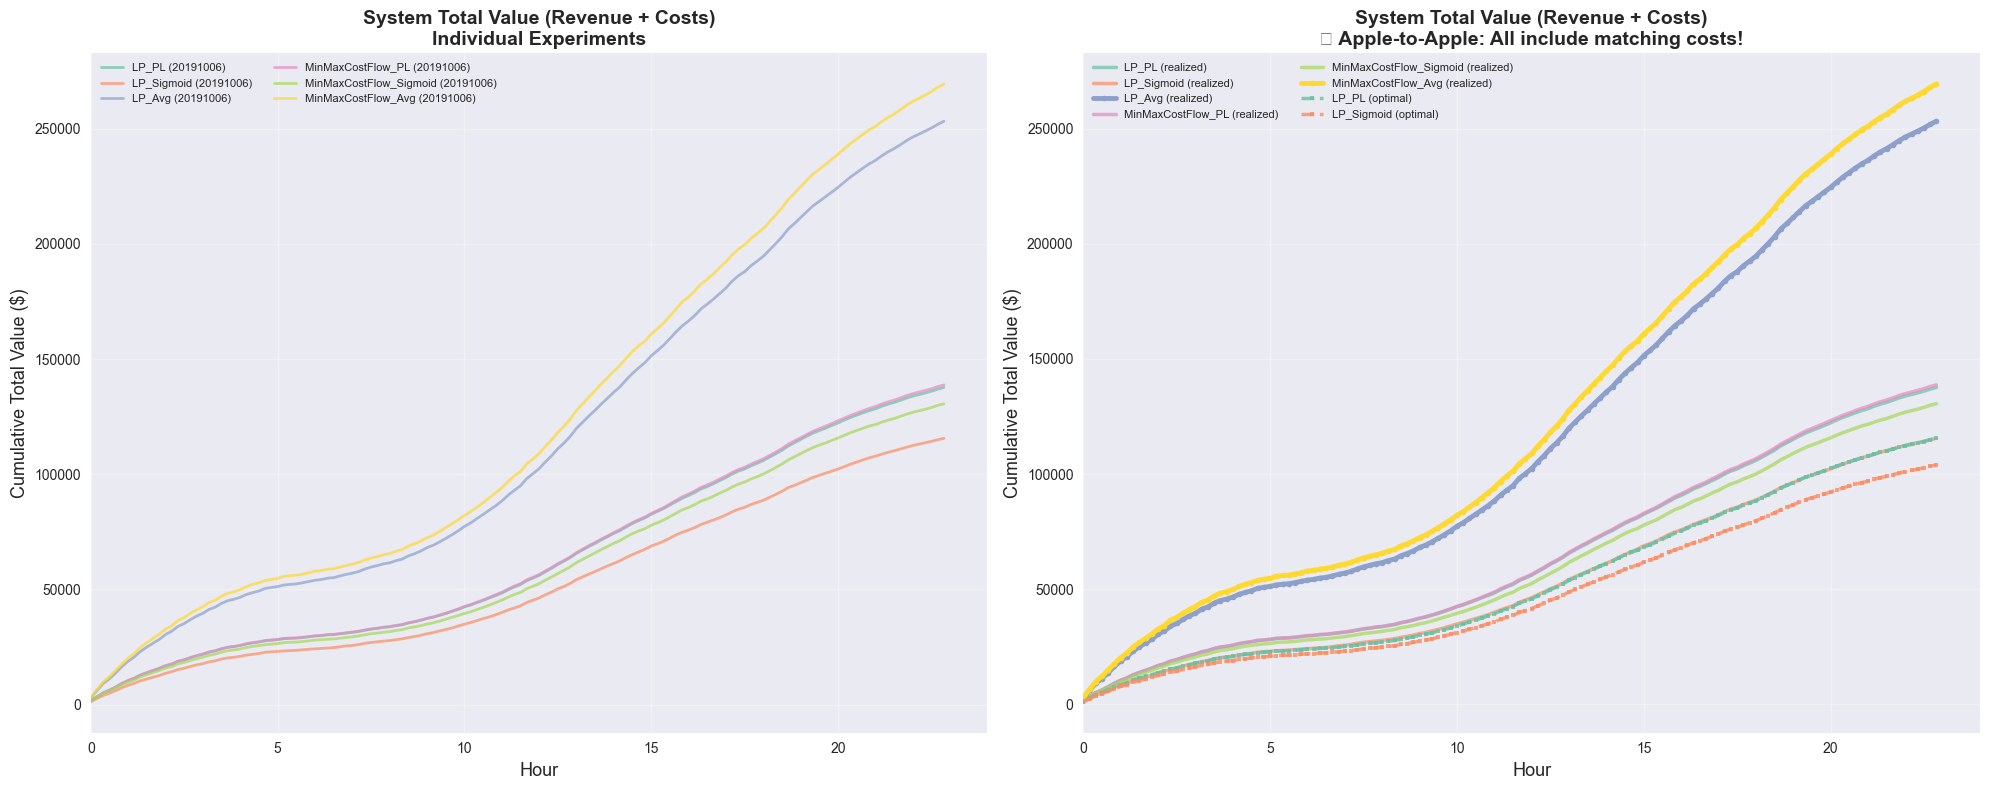


🎉 ANALYSIS COMPLETE!

📁 Plots: /Users/borker/mgr/taxibenchmark/plots

💡 Key Insights:
  • Revenue plot shows what customers pay (profit field)
  • Total value plot shows system efficiency (profit + edge_weights)
  • Each method shown with PL, Sigmoid, and Average
  • LP optimal lines show theoretical best (dashed)
  • All comparisons are apple-to-apple!


In [30]:
# 🚀 RUN COMPLETE ANALYSIS

print("🚀 Loading experiments...\n")
experiments_data = load_all_experiments(EXPERIMENT_IDS)

if not experiments_data:
    print("❌ No data!")
else:
    print(f"\n✅ Loaded {len(experiments_data)} experiments")
    print(f"   Total records: {sum(len(df) for df in experiments_data.values()):,}")
    
    # Summary
    print("\n")
    summary = print_summary(experiments_data)
    
    # Plots
    print("\n🎨 GENERATING PLOTS\n")
    
    print("📊 1. Customer Revenue (Business Perspective)")
    plot_customer_revenue(experiments_data)
    
    print("\n📊 2. System Total Value (Efficiency Perspective - Apple-to-Apple!)")
    plot_system_total_value(experiments_data)
    
    print("\n" + "="*100)
    print("🎉 ANALYSIS COMPLETE!")
    print("="*100)
    print(f"\n📁 Plots: {PLOTS_DIR.absolute()}")
    print("\n💡 Key Insights:")
    print("  • Revenue plot shows what customers pay (profit field)")
    print("  • Total value plot shows system efficiency (profit + edge_weights)")
    print("  • Each method shown with PL, Sigmoid, and Average")
    print("  • LP optimal lines show theoretical best (dashed)")
    print("  • All comparisons are apple-to-apple!")

## 📖 Understanding the Plots

### Left Plots (Individual Experiments)
- Show each experiment separately
- Different line styles per experiment date
- All 3 variants visible: Method_PL, Method_Sigmoid, Method_Avg

### Right Plots (Averaged Across Experiments)  
- Average across all experiment dates
- Method_Avg shown with markers and confidence bands (bold)
- Method_PL and Method_Sigmoid shown as thinner lines
- LP optimal shown as dashed lines (for PL and Sigmoid separately)

### Color Scheme (Set2)
- **Green tones:** LP variants
- **Pink/Yellow tones:** MinMaxCostFlow variants
- Colorblind-friendly

### Three Acceptance Function Variants

**Why 3 variants per method?**

Each method optimizes prices for BOTH acceptance functions:
1. **PL** - Piecewise linear acceptance (original Hikima)
2. **Sigmoid** - Smooth sigmoid acceptance (alternative)
3. **Avg** - Combined average of PL and Sigmoid

**When to use which:**
- **PL only:** Compare to Hikima's original results
- **Sigmoid only:** If you assume sigmoid customer behavior
- **Average:** Robust comparison across both models

### Customer Revenue vs System Total Value

**Example with one matched customer:**

```
Customer pays: $30
Edge weight (driver travel cost): -$15

Customer Revenue = $30 (what business earns)
System Total Value = $30 - $15 = $15 (accounting for costs)
```

**Which to use:**
- **Revenue:** For business/financial analysis
- **Total Value:** For system optimization (LP comparison)